# LOADING THE NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

# IMPORTING THE DATASET

In [2]:
true = pd.read_csv("../data/interim/True.csv")
false = pd.read_csv("../data/interim/Fake.csv")

# DATA VISUALIZATION AND PREPROCESSING

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true['category'] = 1
false['category'] = 0

In [6]:
df = pd.concat([true,false]) #Merging the 2 datasets

**MERGING ALL THE TEXT DATA INTO 1 COLUMN i.e. 'text'**

In [7]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [8]:
# Solution to getting the nltk set up properly
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# nltk.download()

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [30]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**DATA CLEANING**

In [32]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [33]:
df

,text,category
0,WASHINGTON (Reuters) head conservative Republi...,1
1,WASHINGTON (Reuters) Transgender people allowe...,1
2,WASHINGTON (Reuters) special counsel investiga...,1
3,WASHINGTON (Reuters) Trump campaign adviser Ge...,1
4,SEATTLE/WASHINGTON (Reuters) President Donald ...,1
...,...,...
23476,21st Century Wire says 21WIRE reported earlier...,0
23477,21st Century Wire says familiar theme. Wheneve...,0
23478,Patrick Henningsen 21st Century WireRemember O...,0
23479,21st Century Wire says Al Jazeera America go h...,0


In [34]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [35]:
len(corpus)

11069115

In [36]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!', 'Good work', 'Great effort', 'nice work', 'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

In [37]:
t.texts_to_sequences(docs)

[[2, 3], [4, 1], [5, 6], [7, 1], [8]]

**Splitting the data into 2 parts - training and testing data**

In [38]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [39]:
max_features = 10000
maxlen = 300

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [40]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [41]:
x_train.shape

(33673, 300)

In [42]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [43]:
X_test

array([[   0,    0,    0, ..., 2942, 4027, 6287],
       [   0,    0,    0, ..., 2176, 2814,   41],
       [   0,    0,    0, ..., 3339, 2938,   41],
       ...,
       [   0,    0,    0, ..., 3478,  530,  833],
       [2365, 1315, 4080, ...,  291,  498,   41],
       [   0,    0,    0, ...,  767,   69,   28]], dtype=int32)

# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
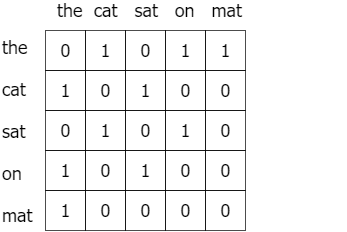

**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

**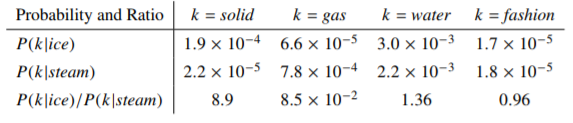
The behavior of P_ik/P_jk for various words
Consider the entity
P_ik/P_jk where P_ik = X_ik/X_i
Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i).
You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”),
is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1),
is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1),
is related or unrelated to either words, then P_ik/P_jk will be close to 1
So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.**

**Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010**

In [71]:
EMBEDDING_FILE = '../data/external/glove.twitter.27B.100d.txt'

In [72]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [73]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


**Some Model Parameters**

In [74]:
batch_size = 256
epochs = 10
embed_size = 100

In [75]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

# TRAINING THE MODEL

In [76]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [78]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size = batch_size , 
                    validation_data = (X_test,y_test) , 
                    epochs = epochs , 
                    callbacks = [learning_rate_reduction])


Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 165s 5ms/step - loss: 0.1689 - accuracy: 0.9308 - val_loss: 0.0446 - val_accuracy: 0.9847
Epoch 2/10
33673/33673 [==============================] - 168s 5ms/step - loss: 0.0404 - accuracy: 0.9861 - val_loss: 0.0148 - val_accuracy: 0.9962
Epoch 3/10
33673/33673 [==============================] - 166s 5ms/step - loss: 0.0159 - accuracy: 0.9944 - val_loss: 0.0122 - val_accuracy: 0.9963
Epoch 4/10
33673/33673 [==============================] - 166s 5ms/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0116 - val_accuracy: 0.9971
Epoch 5/10
33673/33673 [==============================] - 160s 5ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0088 - val_accuracy: 0.9977
Epoch 6/10
33673/33673 [==============================] - 166s 5ms/step - loss: 0.0089 - accuracy: 0.9968 - val_loss: 0.0063 - val_accuracy: 0.9979
Epoch 7/10
33673/33673 [==============================] - 163

# ANALYSIS AFTER TRAINING OF MODEL

In [79]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

33673/33673 [==============================] - 77s 2ms/step
Accuracy of the model on Training Data is -  99.97920989990234 %
11225/11225 [==============================] - 26s 2ms/step
Accuracy of the model on Testing Data is -  99.80400800704956 %


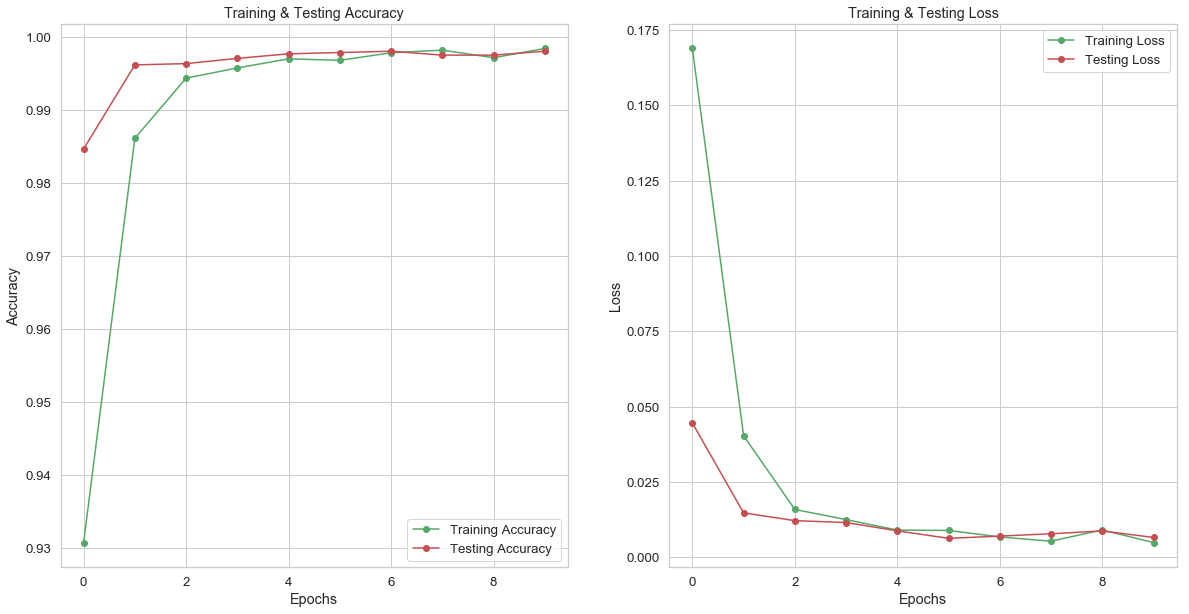

In [80]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [81]:
pred = model.predict_classes(X_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [82]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [83]:
cm = confusion_matrix(y_test,pred)
cm

array([[5848,   10],
       [  12, 5355]])

In [84]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(64.5, 0.5, 'Actual')

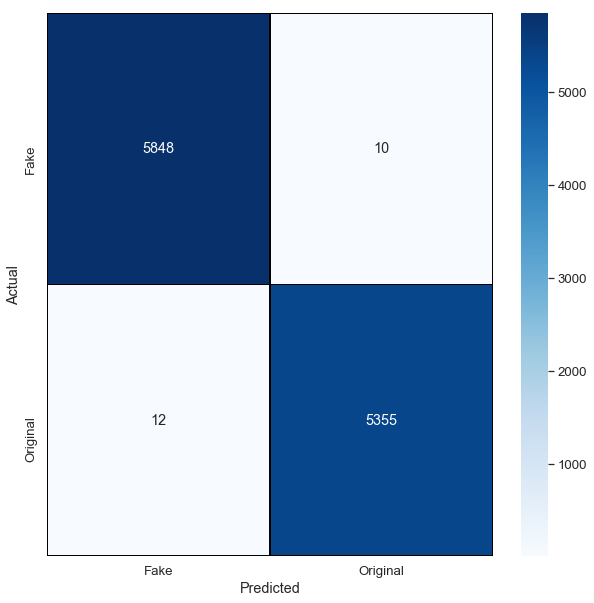

In [85]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")